In [7]:
!pip3 install textblob
!pip3 install xgboost
!pip3 install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 1.3/1.3 MB 3.8 MB/s eta 0:00:00


In [8]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import nltk
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
import lightgbm

In [10]:
!pip3 install pandas_datareader

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 109.5/109.5 kB 3.2 MB/s eta 0:00:00


In [11]:
# For reading stock data from yahoo
from pandas_datareader.data import DataReader
# For time stamps
from datetime import datetime

In [12]:
# Load the first dataset
columns=['Date','Category','News']
ndf = pd.read_csv("india-news-headlines.csv",names=columns)

In [13]:
print('Showing part of the whole dataset:')
ndf.head(5)

Showing part of the whole dataset:


,Date,Category,News
0,20200101,life-style.events,Happy New Year 2020: Images; Quotes; Wishes; M...
1,20200101,city.bhubaneswar,Bone-clling cold wavecontinues to sweep state
2,20200101,city.hyderabad,T gained 163 sq km forest cover
3,20200101,city.hyderabad,Draft electoral rolls published
4,20200101,city.koc,Invasive species increasing in Kerala's core f...


In [14]:
ndf.drop(0, inplace=True)
ndf.drop('Category', axis = 1, inplace=True)
print('Showing part of the whole dataset:')
ndf.head(-5)

Showing part of the whole dataset:


,Date,News
1,20200101,Bone-clling cold wavecontinues to sweep state
2,20200101,T gained 163 sq km forest cover
3,20200101,Draft electoral rolls published
4,20200101,Invasive species increasing in Kerala's core f...
5,20200101,Onion price in Hyd dips to Rs 90/kg
...,...,...
90863,20200630,vecle of up stf team bringing gangster vikas d...
90864,20200630,sushant singh rajputs demise fans trend cbifor...
90865,20200630,amitabh bachchans grandson agastya nanda prepp...
90866,20200630,icse isc result 2020 when where to check class...


In [16]:
# Load the second dataset
hisdf = pd.read_csv("BSESN.csv")
hisdf.head(-5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-14,41883.089844,41994.261719,41770.898438,41952.628906,41952.628906,14100.0
1,2020-01-15,41969.859375,41969.859375,41648.109375,41872.730469,41872.730469,6100.0
2,2020-01-16,41924.738281,42059.449219,41812.281250,41932.558594,41932.558594,6600.0
3,2020-01-17,41929.019531,42063.929688,41850.289063,41945.371094,41945.371094,9500.0
4,2020-01-20,42263.000000,42273.871094,41503.371094,41528.910156,41528.910156,7500.0
...,...,...,...,...,...,...,...
242,2021-01-01,NaN,NaN,NaN,NaN,NaN,NaN
243,2021-01-04,48109.171875,48220.468750,47594.468750,48176.800781,48176.800781,13900.0
244,2021-01-05,48037.628906,48486.238281,47903.378906,48437.781250,48437.781250,12200.0
245,2021-01-06,48616.660156,48616.660156,47864.140625,48174.058594,48174.058594,22500.0


# Common Dataset Exploration

In [17]:
# Check for common information of the first datast
ndf["Date"] = pd.to_datetime(ndf["Date"],format='%Y%m%d')
ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90872 entries, 1 to 90872
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    90872 non-null  datetime64[ns]
 1   News    90872 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 1.4+ MB


In [18]:
# Group the headlines for each day
ndf['News'] = ndf.groupby(['Date']).transform(lambda x : ' '.join(x)) 
ndf = ndf.drop_duplicates() 
ndf.reset_index(inplace=True,drop=True)

In [19]:
ndf

,Date,News
0,2020-01-01,Bone-clling cold wavecontinues to sweep state ...
1,2020-01-02,Horoscope Today; 02 January 2020: Read predict...
2,2020-01-03,Bank Holidays in 2020 Mazya Navryac Bayko upda...
3,2020-01-04,Mamta Mohandas plays a nurse in Lalbagh Tolly ...
4,2020-01-05,Homing in on 2020 Beauty in blue Live it up in...
...,...,...
177,2020-06-26,Containment zone residents slam gh prices char...
178,2020-06-27,like me i wont let you have a toxic relationsp...
179,2020-06-28,Atanu Ghosh plans to rewrite old scripts to ma...
180,2020-06-29,6 hot and stylish bikini looks of Katrina Kaif...


In [20]:
# Check for any duplicated values
ndf.isnull().sum()

Date    0
News    0
dtype: int64

In [36]:
hisdf.isnull().sum()

Date      0
Open      2
High      2
Low       2
Close     2
Volume    2
dtype: int64

In [41]:
hisdf.dropna(inplace=True)

In [21]:
len(ndf)

182

In [43]:
hisdf=hisdf[["Date","Open","High","Low","Close","Volume"]]
hisdf.head(-5)

,Date,Open,High,Low,Close,Volume
0,2020-01-14,41883.089844,41994.261719,41770.898438,41952.628906,14100.0
1,2020-01-15,41969.859375,41969.859375,41648.109375,41872.730469,6100.0
2,2020-01-16,41924.738281,42059.449219,41812.281250,41932.558594,6600.0
3,2020-01-17,41929.019531,42063.929688,41850.289063,41945.371094,9500.0
4,2020-01-20,42263.000000,42273.871094,41503.371094,41528.910156,7500.0
...,...,...,...,...,...,...
241,2020-12-31,47753.109375,47896.968750,47602.121094,47751.328125,13900.0
243,2021-01-04,48109.171875,48220.468750,47594.468750,48176.800781,13900.0
244,2021-01-05,48037.628906,48486.238281,47903.378906,48437.781250,12200.0
245,2021-01-06,48616.660156,48616.660156,47864.140625,48174.058594,22500.0


In [44]:
# Check for common information of the second dataset
hisdf["Date"]= pd.to_datetime(hisdf["Date"])
hisdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 251
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    250 non-null    datetime64[ns]
 1   Open    250 non-null    float64       
 2   High    250 non-null    float64       
 3   Low     250 non-null    float64       
 4   Close   250 non-null    float64       
 5   Volume  250 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 13.7 KB


In [45]:
hisdf.describe()

,Open,High,Low,Close,Volume
count,250.000000,250.000000,250.000000,250.000000,250.000000
mean,38269.162969,38540.293734,37872.438492,38212.026945,19444.000000
std,5156.339989,5041.892693,5268.673199,5187.053337,16336.653543
min,26499.810547,27462.869141,25638.900391,25981.240234,0.000000
25%,34369.659179,34779.932618,33975.389648,34257.097656,13750.000000
50%,38489.480469,38750.359375,38234.869140,38425.974610,17200.000000
75%,41277.041992,41398.549805,41069.779297,41166.371094,21350.000000
max,49763.929688,49795.191406,49182.371094,49584.160156,188300.000000


In [46]:
# Check for duplicated values
hisdf.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [47]:
len(hisdf)

250

Text(0, 0.5, 'BSESN')

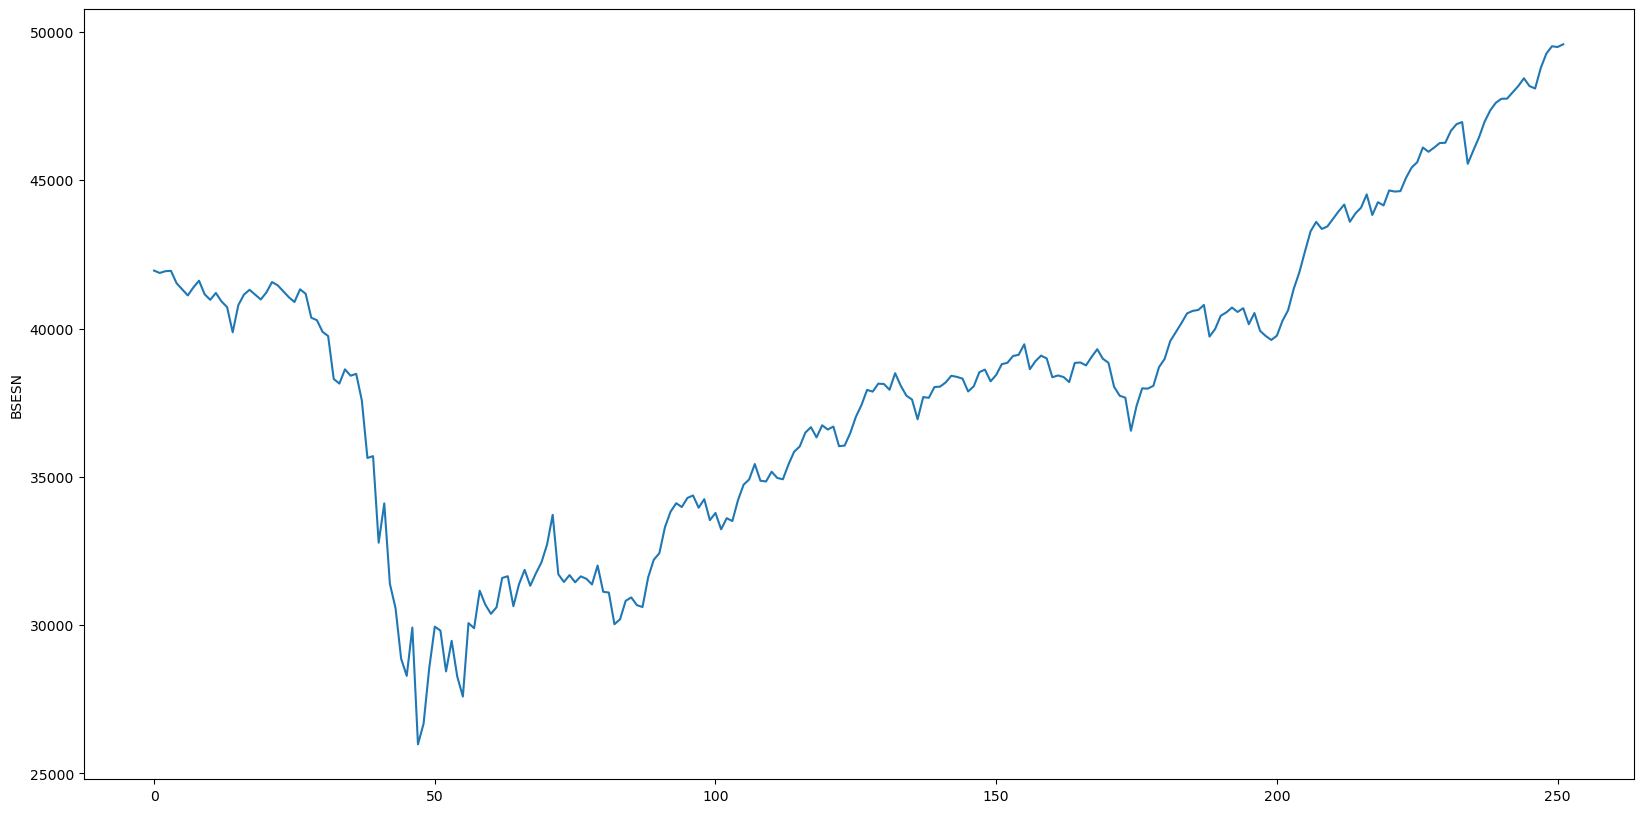

In [48]:
# Figure plot
plt.figure(figsize=(20,10))
hisdf['Close'].plot()
plt.ylabel('BSESN')

# Remove Unwanted Characters from the News

In [49]:
#removing unwanted characters from the News
ndf.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
ndf["News"].head(5)

0    Bone clling cold wavecontinues to sweep state ...
1    Horoscope Today     January       Read predict...
2    Bank Holidays in      Mazya Navryac Bayko upda...
3    Mamta Mohandas plays a nurse in Lalbagh Tolly ...
4    Homing in on      Beauty in blue Live it up in...
Name: News, dtype: object

# Historical Analysis

### Plot the Moving Average

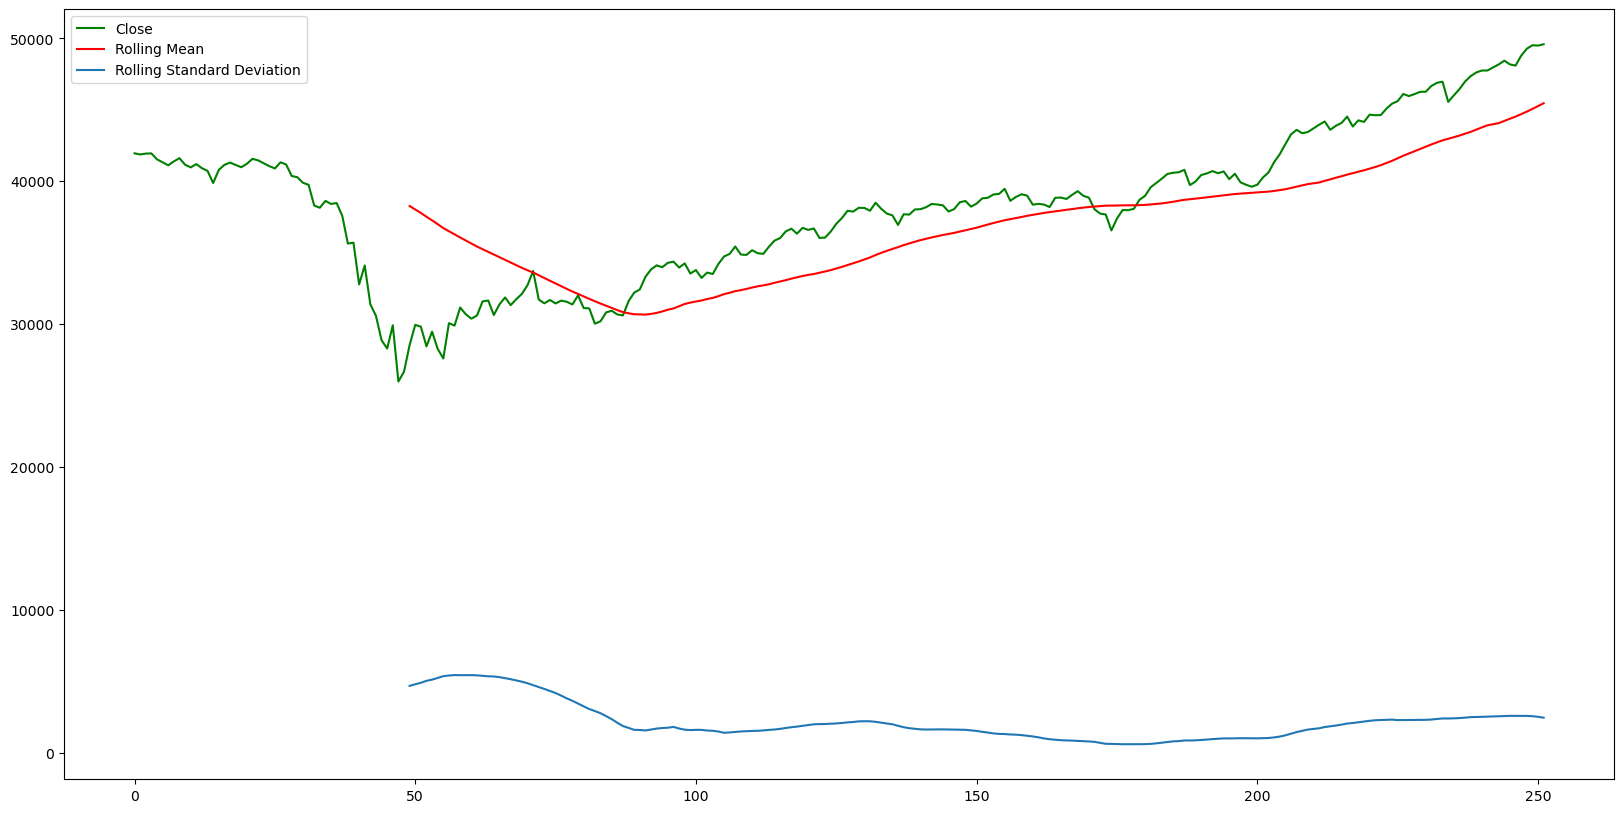

In [50]:
#Plotting moving average
close = hisdf['Close']

ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(20,10))
hisdf['Close'].plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()

### Plot the Returns

Text(0.5, 1.0, 'Returns')

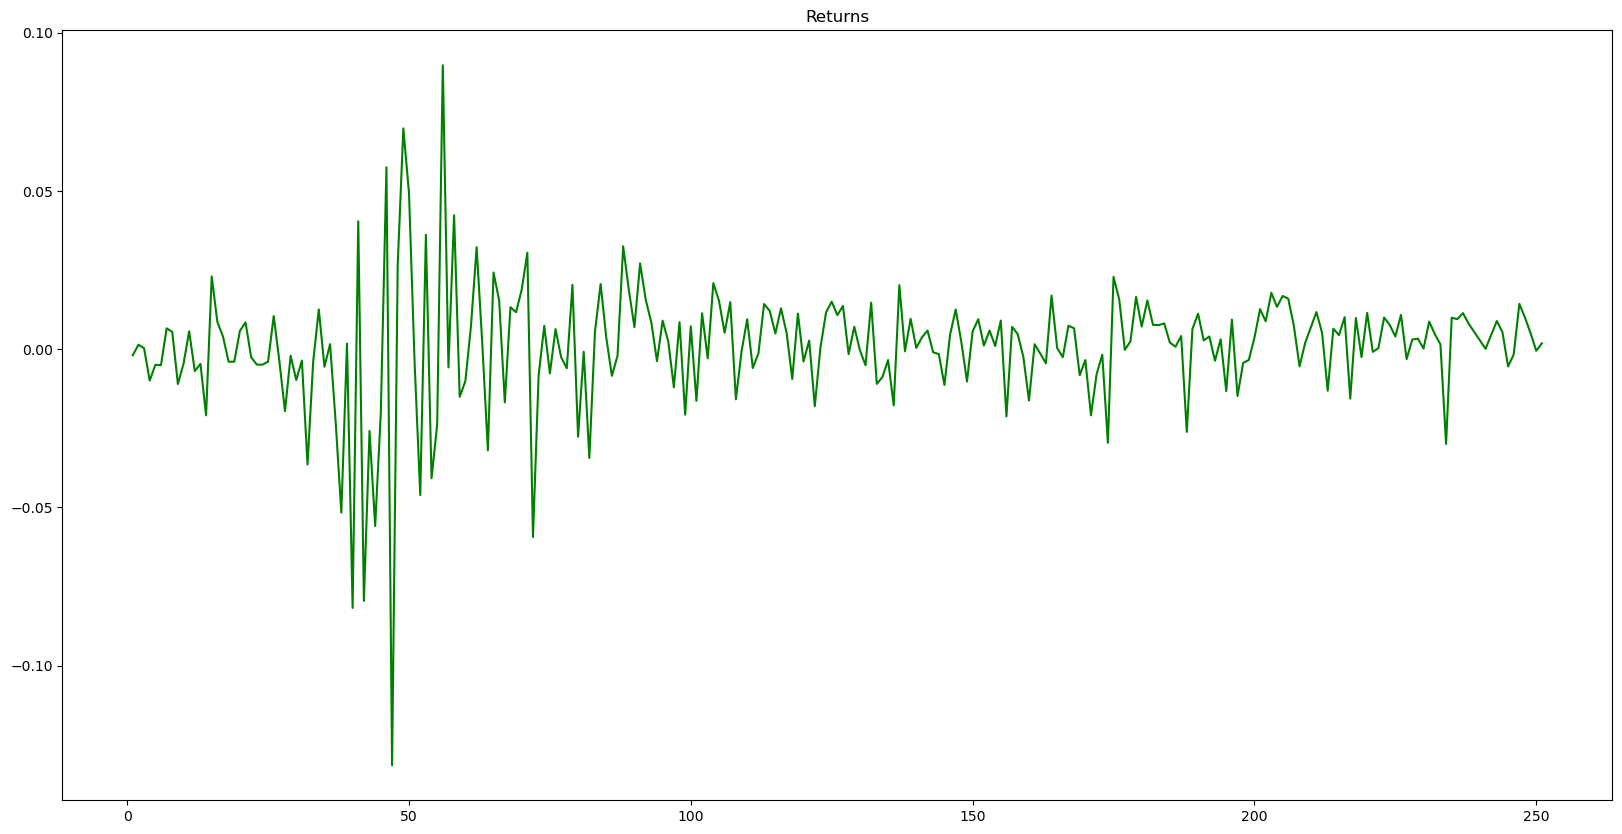

In [51]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (20,10))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [52]:
# Train test split
train = hisdf[:1219]
test = hisdf[1219:]

# Rolling mean and Standard Deviation

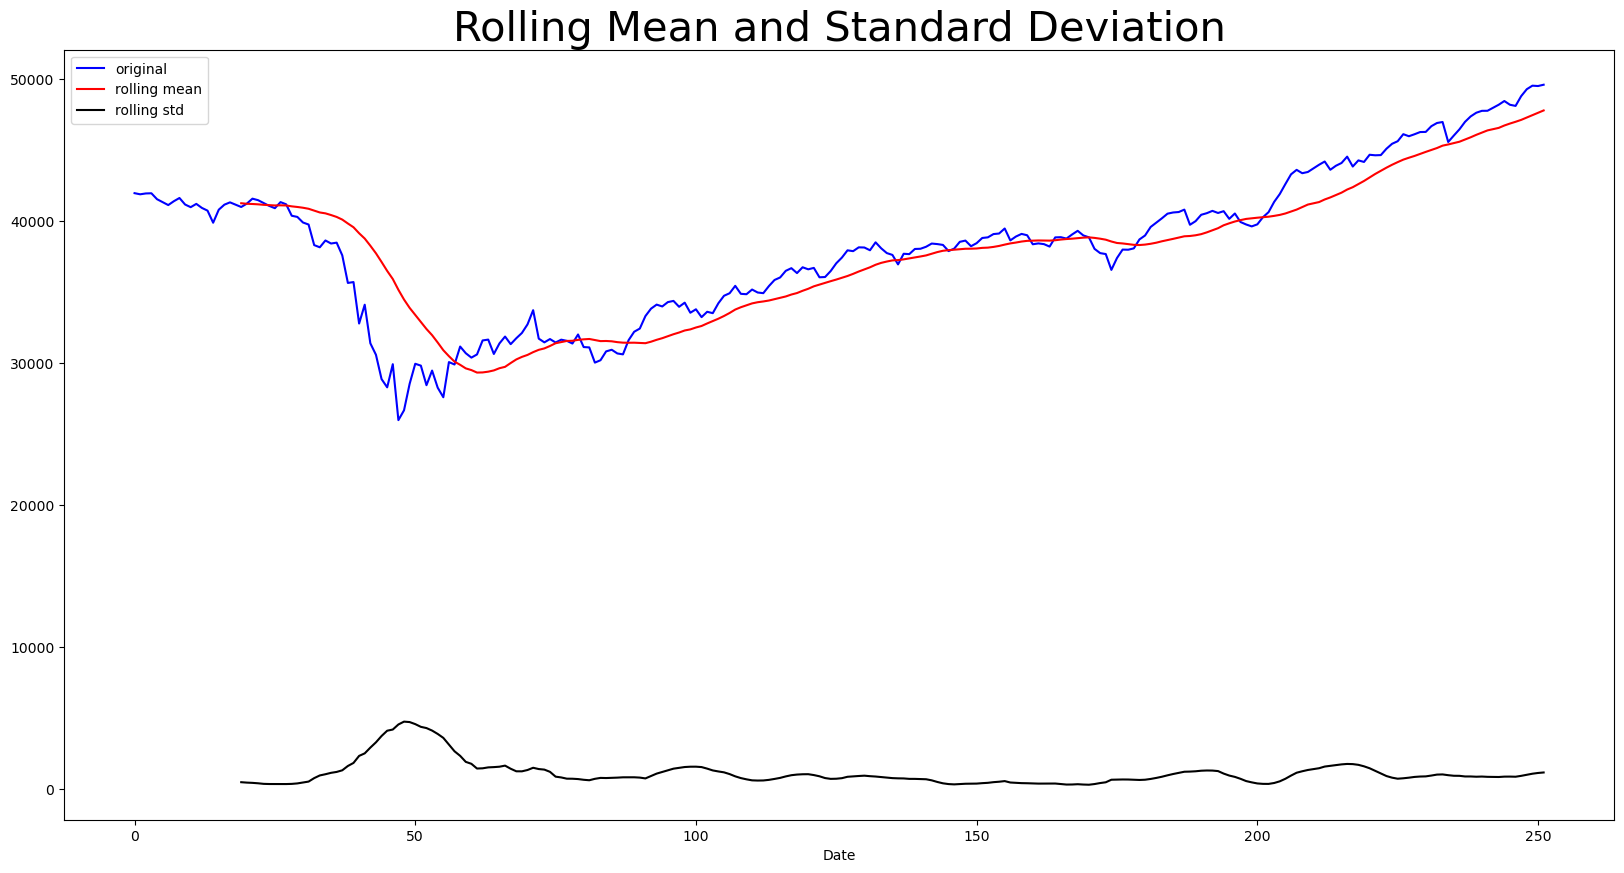

Results of dickey fuller test
ADF Test Statistic : -0.4567783967989093
p-value : 0.9001785338829051
#Lags Used : 7
Number of Observations Used : 242
Weak evidence against null hypothesis, time series is non-stationary 


In [53]:
#Stationarity test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

 #Determine the rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (20,10))
 plt.plot(timeseries, color = 'blue', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'black', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 30)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

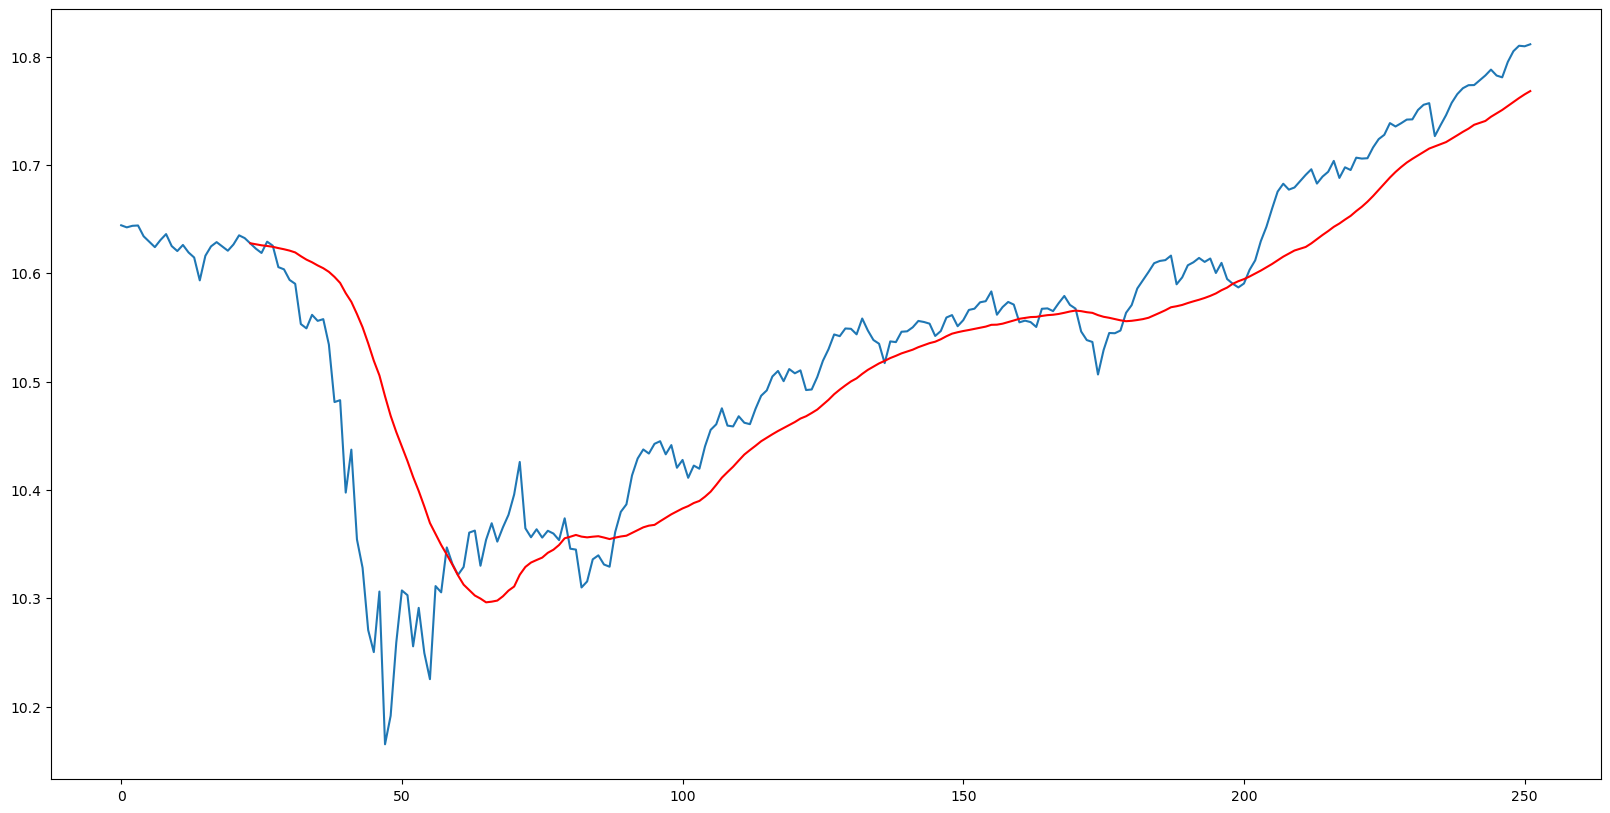

In [54]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (20,10))
plt.plot(train_log) 
plt.plot(mav, color = 'red')

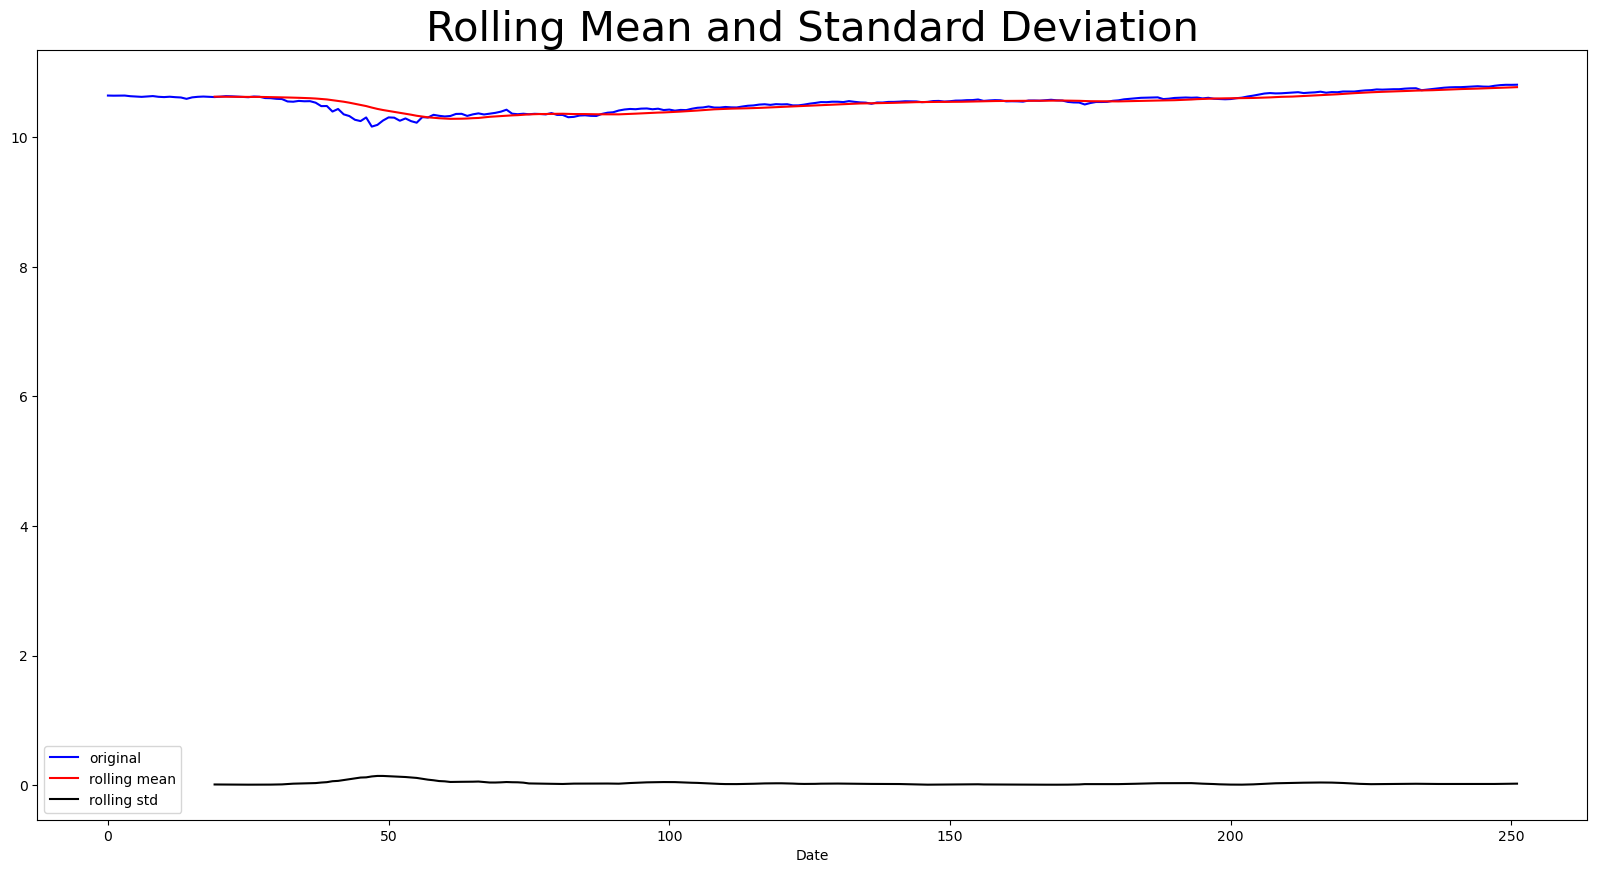

Results of dickey fuller test
ADF Test Statistic : -0.8516329649858166
p-value : 0.8034830442501073
#Lags Used : 7
Number of Observations Used : 242
Weak evidence against null hypothesis, time series is non-stationary 


In [55]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

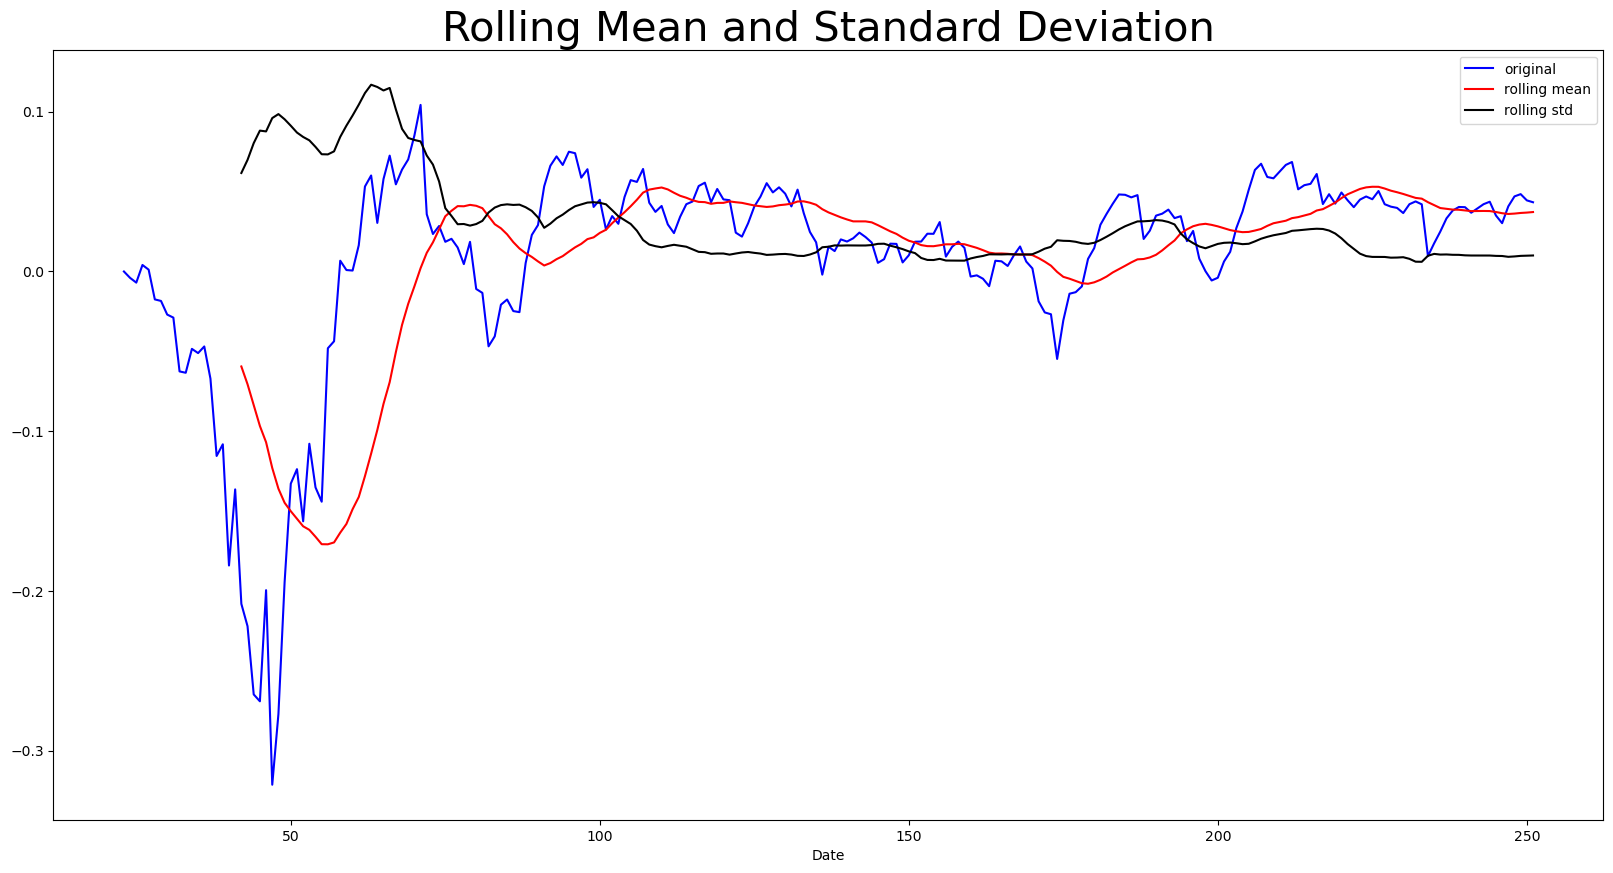

Results of dickey fuller test
ADF Test Statistic : -3.0370567165059876
p-value : 0.03157571448052179
#Lags Used : 7
Number of Observations Used : 219
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [56]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [58]:
#Using auto arima to make predictions using log data
!pip3 install pmdarima
from pmdarima import auto_arima

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 613.3/613.3 kB 7.7 MB/s eta 0:00:00
     ---------------------------------------- 2.8/2.8 MB 3.8 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [59]:
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1226.892, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1226.882, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1229.578, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1229.045, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1228.613, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1228.066, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1227.789, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1226.210, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1231.224, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1229.743, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1229.427, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1230.693, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1227.892, Time=0.16 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.324 seconds


Text(0, 0.5, 'Actual Stock Price')

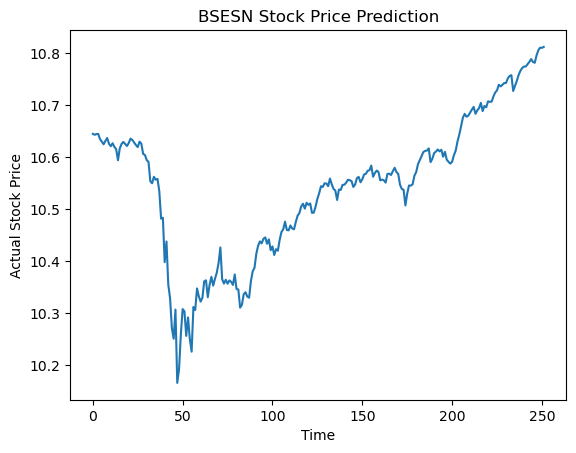

In [60]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

# Error Calculation

In [61]:
#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.